In [1]:
import pandas as pd
import numpy as np
import pdb
from lumina.genetic.signal.method import *
from lumina.genetic.metrics.ts_pnl import calculate_ful_ts_ret
import ultron.factor.empyrical as empyrical
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from kdutils.common import *
from kdutils.macro2 import *
from kdutils.data import fetch_main_market

In [3]:
instruments = 'ims'
strategy_settings = {
        'commission': COST_MAPPING[INSTRUMENTS_CODES[instruments]],
        'slippage': 0,
        'size': CONT_MULTNUM_MAPPING[INSTRUMENTS_CODES[instruments]]
    }

In [4]:
begin_date ='2023-12-10'
end_date = '2024-04-10'

market_data = fetch_main_market(begin_date=begin_date,
                             end_date=end_date,
                             codes=['IM'])
market_data_indexed = market_data.set_index('trade_time')
aggregation_rules = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum',
        'value': 'sum'
    }
market_data_15min = market_data_indexed.resample('15T', label='right', closed='right').agg(aggregation_rules)
market_data['vwap'] = market_data['value'] / market_data['volume'] / 200
market_data_15min.dropna(inplace=True)
market_data_15min.reset_index(inplace=True)
market_data_15min['code']='IM'

total_data2 = market_data_15min.set_index(['trade_time','code']).unstack()

In [5]:
total_data1 = pd.read_feather('11.feat')
factor_data1 = total_data1[['trade_time','code','pred_alpha']]
return_data1 = total_data1[['trade_time','code','nxt1_ret_15h']]

In [6]:
### 转信号函数
def rolling_rank_discretization(series, window=24, positive_quantile=0.9, negative_quantile=0.1):
    """
    使用严格的历史滚动窗口进行排名离散化，避免任何未来数据。

    参数:
    series: 输入数据，Pandas Series。
    window: 滚动窗口大小（默认10）。
    positive_quantile: 正方向分位数阈值（默认0.9）。
    negative_quantile: 负方向分位数阈值（默认0.1）。

    返回:
    discrete_series: 离散化后的Series，值为-1, 0, 1。
    """
    # 初始化结果Series
    discrete_series = pd.Series(index=series.index, dtype=float)
    
    # 遍历每个窗口
    for i in range(len(series)):
        if i < window - 1:
            # 窗口不足时设置为NaN
            discrete_series.iloc[i] = np.nan
            continue
            
        # 获取当前窗口数据 (严格使用过去window个点)
        window_data = series.iloc[i - window + 1: i + 1] # 包括当前点，但都是历史数据
        
        # 跳过包含NaN值的窗口
        if window_data.isna().any():
            discrete_series.iloc[i] = np.nan
            continue
        
        # 在窗口内计算排名标准化
        rank_data = window_data.rank()
        standardized = (rank_data / rank_data.sum()) - 0.5
        
        # 计算当前窗口的分位数阈值
        pos_threshold = standardized.quantile(positive_quantile)
        neg_threshold = standardized.quantile(negative_quantile)
        
        # 对窗口内的最后一个值（即当前点）进行离散化
        current_standardized = standardized.iloc[-1]
        if current_standardized >= pos_threshold:
            discrete_series.iloc[i] = 1
        elif current_standardized <= neg_threshold:
            discrete_series.iloc[i] = -1
        else:
            discrete_series.iloc[i] = 0
    
    return discrete_series

In [7]:
factor_data1

,trade_time,code,pred_alpha
0,2024-01-02 10:15:00,IM,0.000417
1,2024-01-02 10:30:00,IM,0.000015
2,2024-01-02 10:45:00,IM,-0.000010
3,2024-01-02 11:15:00,IM,0.000022
4,2024-01-02 13:30:00,IM,0.000297
...,...,...,...
1917,2025-03-06 13:30:00,IM,0.000273
1918,2025-03-06 14:00:00,IM,0.000371
1919,2025-03-06 14:15:00,IM,0.000529
1920,2025-03-06 14:30:00,IM,0.000621


In [8]:
def singal_func(factors_data, signal_method, **signal_params):
    pos_data = eval(signal_method)(factor_data=factors_data,
                                       **signal_params)
    pos_data = pos_data.reset_index().set_index('trade_time')[['IM']]
    pos_data.columns = pd.MultiIndex.from_tuples([('pos','IM')])
    return pos_data


In [9]:
def strategy_func(pos_data, total_data, strategy_method, **strategy_params):
    pos_data = eval(strategy_method)(signal=pos_data,
                                     total_data=total_data,
                                       **strategy_params)
    return pos_data


In [10]:
def calc(signal_data, name):
    df1 = calculate_ful_ts_ret(pos_data=signal_data,
                                  total_data=total_data2.copy(0),
                                  strategy_settings=strategy_settings)
    returns2 = df1['a_ret']
    returns2.name = name
    return returns2

In [11]:
factors_data2 = factor_data1.rename(columns={'pred_alpha':'transformed'}).set_index(['trade_time','code'])
factors_data2.head()

,,transformed
trade_time,code,
2024-01-02 10:15:00,IM,0.000417
2024-01-02 10:30:00,IM,0.000015
2024-01-02 10:45:00,IM,-0.000010
2024-01-02 11:15:00,IM,0.000022
2024-01-02 13:30:00,IM,0.000297


In [12]:
res = {}

In [13]:
base_signal = factor_data1.copy()
base_signal['transformed'] = base_signal.groupby('code').apply(lambda x: rolling_rank_discretization(
    x['pred_alpha'], window=24, positive_quantile=0.7, negative_quantile=0.3)).T
base_signal = base_signal[['trade_time','code','transformed']]
base_signal = base_signal.set_index('trade_time')[['transformed']]
base_signal.columns = pd.MultiIndex.from_tuples([('pos','IM')])
res['base_signal'] =  calc(base_signal, 'base_signal')
base_signal.head()

,pos
,IM
trade_time,
2024-01-02 10:15:00,NaN
2024-01-02 10:30:00,NaN
2024-01-02 10:45:00,NaN
2024-01-02 11:15:00,NaN
2024-01-02 13:30:00,NaN


In [14]:
signal_method = 'mean_signal'
signal_params = {'roll_num': 20, 'threshold': 0.3}
signal1 = singal_func(factors_data=factors_data2, signal_method=signal_method, **signal_params)
res[signal_method] =  calc(signal1, signal_method)
signal1.head()

,pos
,IM
trade_time,
2024-01-02 10:15:00,0
2024-01-02 10:30:00,0
2024-01-02 10:45:00,0
2024-01-02 11:15:00,0
2024-01-02 13:30:00,0


In [15]:
signal_method = 'simple_signal'
signal_params = {'roll_num': 40, 'threshold': 0.4}
signal2 = singal_func(factors_data=factors_data2, signal_method=signal_method, **signal_params)
res[signal_method] =  calc(signal2, signal_method)
signal2.head()

,pos
,IM
trade_time,
2024-01-02 10:15:00,0
2024-01-02 10:30:00,0
2024-01-02 10:45:00,0
2024-01-02 11:15:00,0
2024-01-02 13:30:00,0


In [16]:
signal_method = 'simple_signal'
signal_params = {'roll_num': 40, 'threshold': 0.4}
signal3 = singal_func(factors_data=factors_data2, signal_method=signal_method, **signal_params)
res[signal_method] =  calc(signal3, signal_method)
signal3.head()

,pos
,IM
trade_time,
2024-01-02 10:15:00,0
2024-01-02 10:30:00,0
2024-01-02 10:45:00,0
2024-01-02 11:15:00,0
2024-01-02 13:30:00,0


In [17]:
signal_method = 'momentum_signal'
signal_params = {'roll_num': 40, 'threshold': 0.2}
signal4 = singal_func(factors_data=factors_data2, signal_method=signal_method, **signal_params)
res[signal_method] =  calc(signal4, signal_method)
signal4.head()

,pos
,IM
trade_time,
2024-01-02 10:15:00,0
2024-01-02 10:30:00,0
2024-01-02 10:45:00,0
2024-01-02 11:15:00,0
2024-01-02 13:30:00,0


In [18]:
signal_method = 'icu_signal'
signal_params = {'roll_num': 40, 'threshold': 0.2}
signal5 = singal_func(factors_data=factors_data2, signal_method=signal_method, **signal_params)
res[signal_method] =  calc(signal5, signal_method)
signal5.head()

,pos
,IM
trade_time,
2024-01-02 10:15:00,0
2024-01-02 10:30:00,0
2024-01-02 10:45:00,0
2024-01-02 11:15:00,0
2024-01-02 13:30:00,0


In [19]:
signal_method = 'quantile_signal'
signal_params = {'roll_num': 40, 'threshold': 0.4}
signal6 = singal_func(factors_data=factors_data2, signal_method=signal_method, **signal_params)
res[signal_method] =  calc(signal6, signal_method)
signal6.head()

,pos
,IM
trade_time,
2024-01-02 10:15:00,0
2024-01-02 10:30:00,0
2024-01-02 10:45:00,0
2024-01-02 11:15:00,0
2024-01-02 13:30:00,0


In [20]:
signal_method = 'volatility_signal'
signal_params = {'roll_num': 40, 'threshold': 0.4}
signal7 = singal_func(factors_data=factors_data2, signal_method=signal_method, **signal_params)
res[signal_method] =  calc(signal7, signal_method)
signal7.head()

,pos
,IM
trade_time,
2024-01-02 10:15:00,0
2024-01-02 10:30:00,0
2024-01-02 10:45:00,0
2024-01-02 11:15:00,0
2024-01-02 13:30:00,0


In [22]:
signal_method = 'rollrank_signal'
signal_params = {'roll_num': 24, 'positive_quantile': 0.7}
signal8 = singal_func(factors_data=factors_data2, signal_method=signal_method, **signal_params)
res[signal_method] =  calc(signal8, signal_method)
signal8.head()

,pos
,IM
trade_time,
2024-01-02 10:15:00,0
2024-01-02 10:30:00,0
2024-01-02 10:45:00,0
2024-01-02 11:15:00,0
2024-01-02 13:30:00,0


<Axes: xlabel='trade_time'>

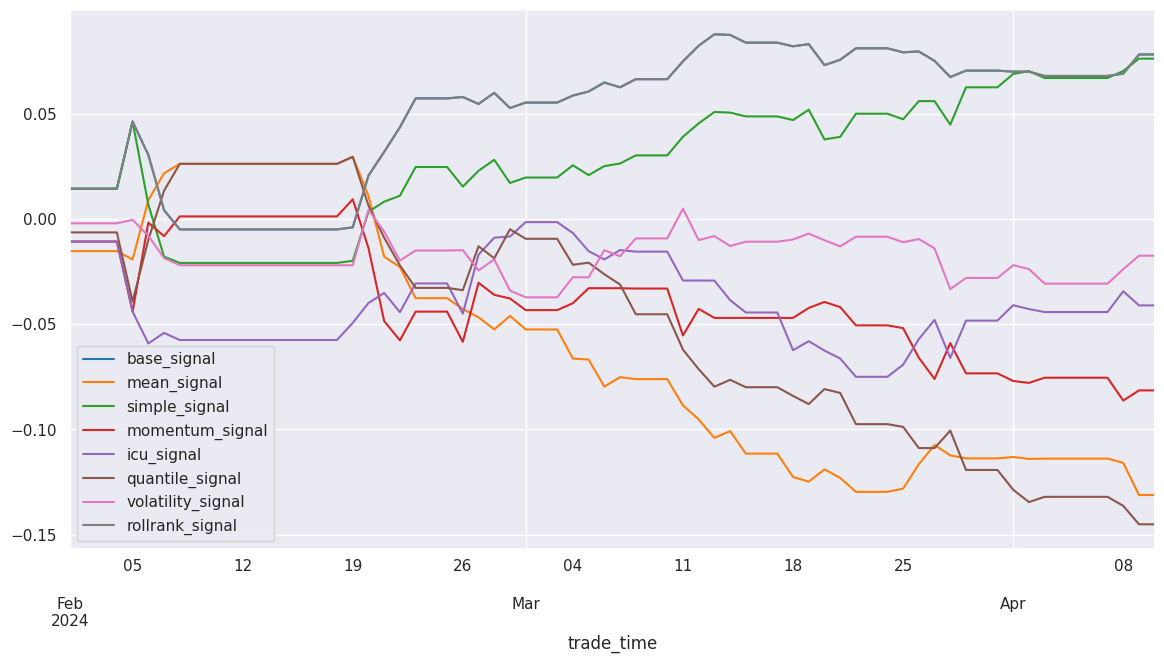

In [23]:
retruns = list(res.values())
pd.concat(retruns,axis=1).dropna().loc['2024-02-01':'2025-03-13'].cumsum().plot(figsize=(14,7))